In [1]:
import os

from cedtrainscheduler.simulator.config import SimulatorConfig
from cedtrainscheduler.simulator.simulator import Simulator
from cedtrainscheduler.simulator.types import Metrics

base_scheduler = "io_tcp"


def run_simulation(scheduler_name, fs_config_path, jobs_count, task_smaple_type):
    """运行模拟并返回结果"""
    current_dir = os.getcwd()  # 使用 os.getcwd() 获取当前工作目录
    base_dir = os.path.dirname(current_dir)

    config = SimulatorConfig(
        cluster_config_path=os.path.join(base_dir, "cedtrainscheduler/cases/cluster/cluster_config.json"),
        fs_config_path=os.path.join(base_dir, "cedtrainscheduler/cases/cluster/" + fs_config_path),
        scheduler_name=scheduler_name,
        task_config_path=os.path.join(
            base_dir, f"cedtrainscheduler/cases/task/case_{task_smaple_type}_{jobs_count}_tasks.csv"
        ),
        output_path=os.path.join(base_dir, "examples/outputs"),
    )

    simulator = Simulator(config)
    results = simulator.simulation()
    return results


# 运行不同调度器的模拟
schedulers = ["greedy", "chronus", "allox", "io_tcp"]
jobs_count_list = [1000, 1300, 1600, 1900, 2200, 2500]
results_dict: dict[int, dict[str, Metrics]] = {}

for jobs_count in jobs_count_list:
    results_dict[jobs_count] = {}
    for scheduler in schedulers:
        results = run_simulation(
            scheduler, fs_config_path="fs_config.json", jobs_count=jobs_count, task_smaple_type="light"
        )
        results_dict[jobs_count][scheduler] = results
        print(results)


Metrics(scheduler_name=<SchedulerType.GREEDY: 10>, task_count=1000, total_runtime=1470037.9835565859, avg_queue_time=89528.50249978284, avg_running_time=101681.35149978282, avg_execution_time=12152.849, cloud_count=774, edge_count=39, terminal_count=187)
Metrics(scheduler_name=<SchedulerType.CHRONUS: 8>, task_count=1000, total_runtime=1470037.9835565859, avg_queue_time=87685.57262858692, avg_running_time=100137.73162858692, avg_execution_time=12452.159, cloud_count=815, edge_count=39, terminal_count=146)
Metrics(scheduler_name=<SchedulerType.ALLOX: 9>, task_count=1000, total_runtime=1470037.9835565859, avg_queue_time=91190.82320095535, avg_running_time=103443.64020095536, avg_execution_time=12252.817, cloud_count=826, edge_count=39, terminal_count=135)
Metrics(scheduler_name=<SchedulerType.IOTCP: 11>, task_count=1000, total_runtime=1470037.9835565859, avg_queue_time=73935.17493555591, avg_running_time=86400.19393555586, avg_execution_time=12465.019, cloud_count=783, edge_count=39, term

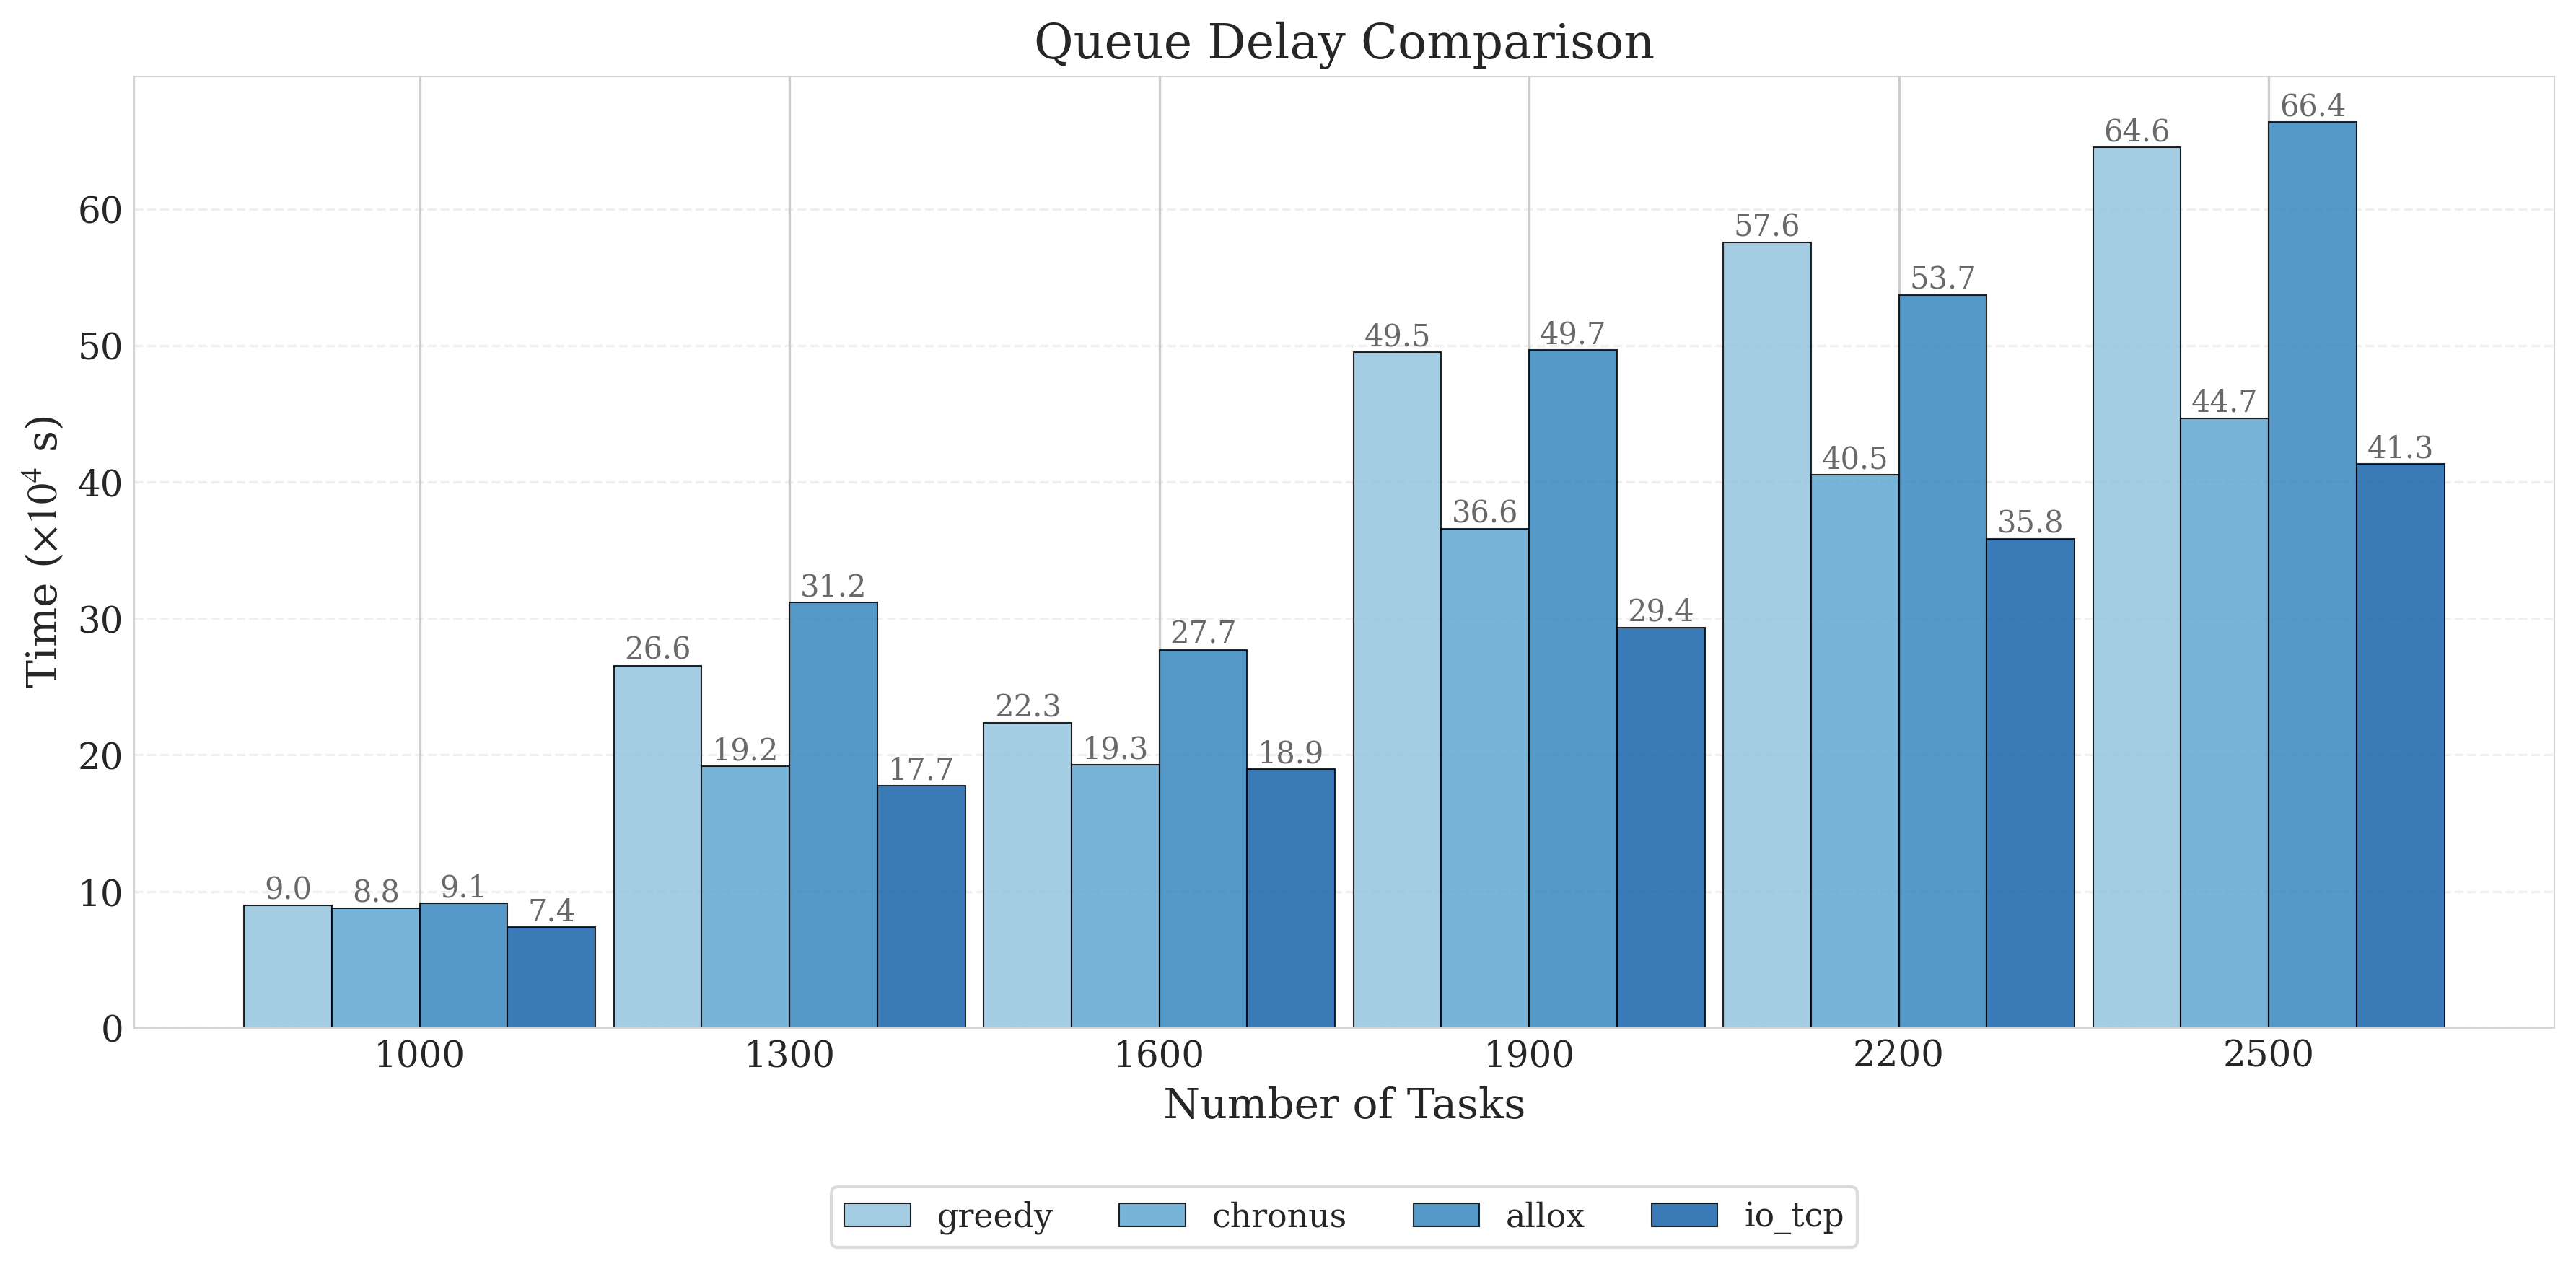

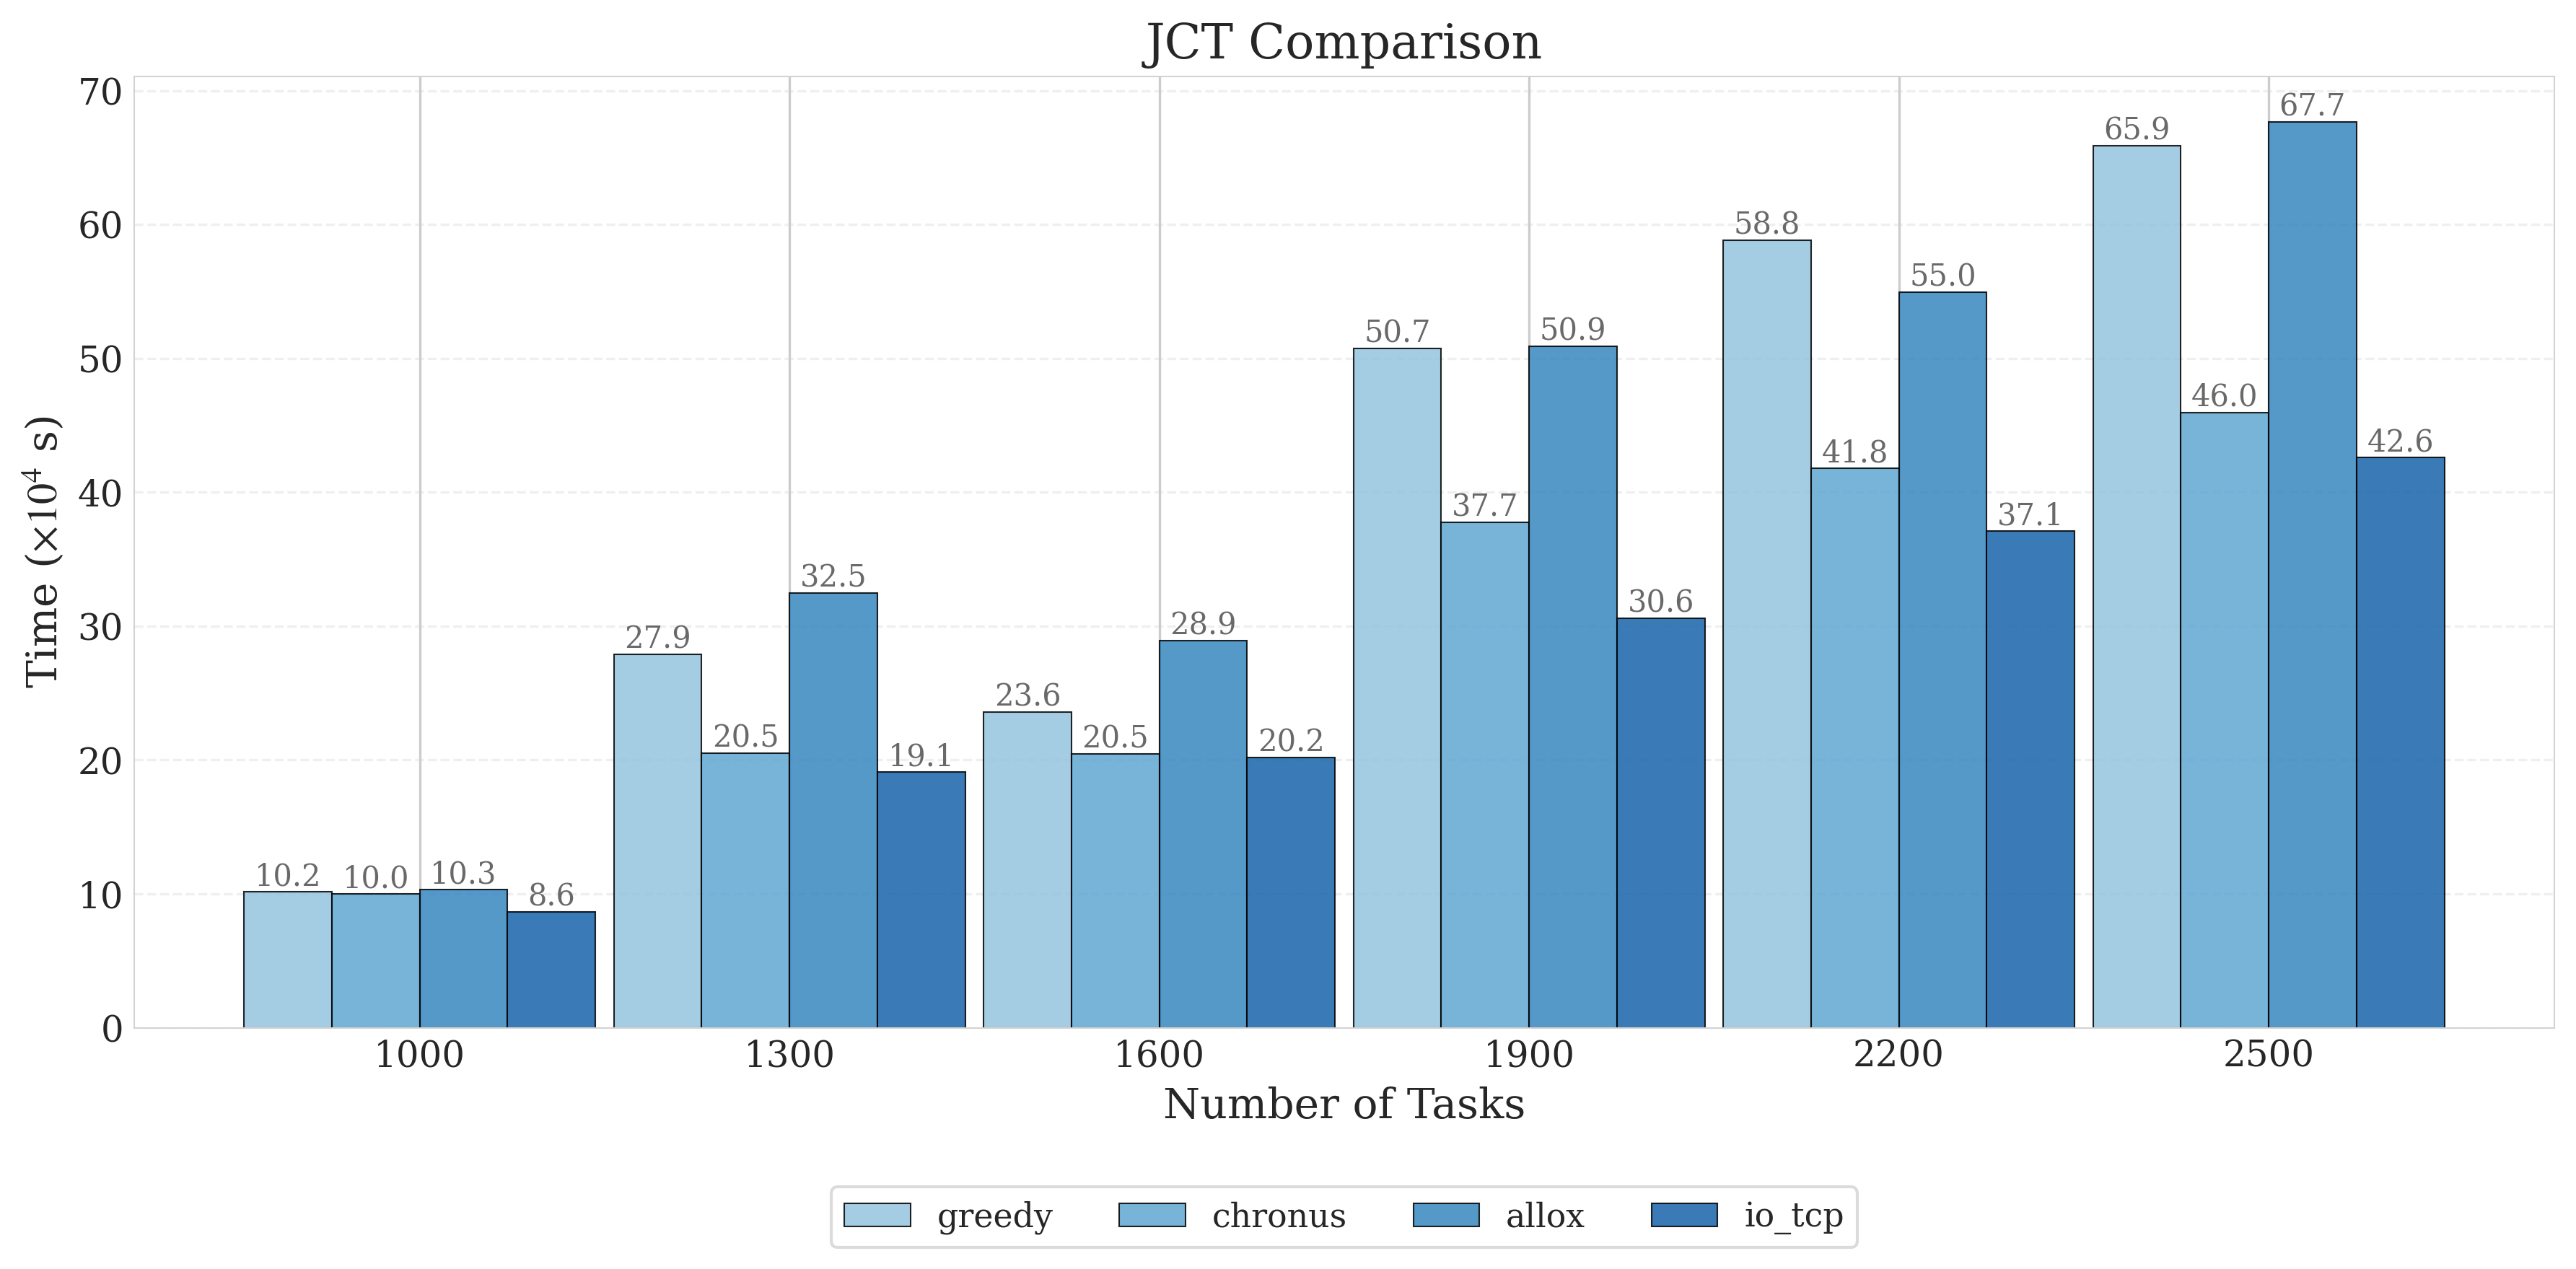

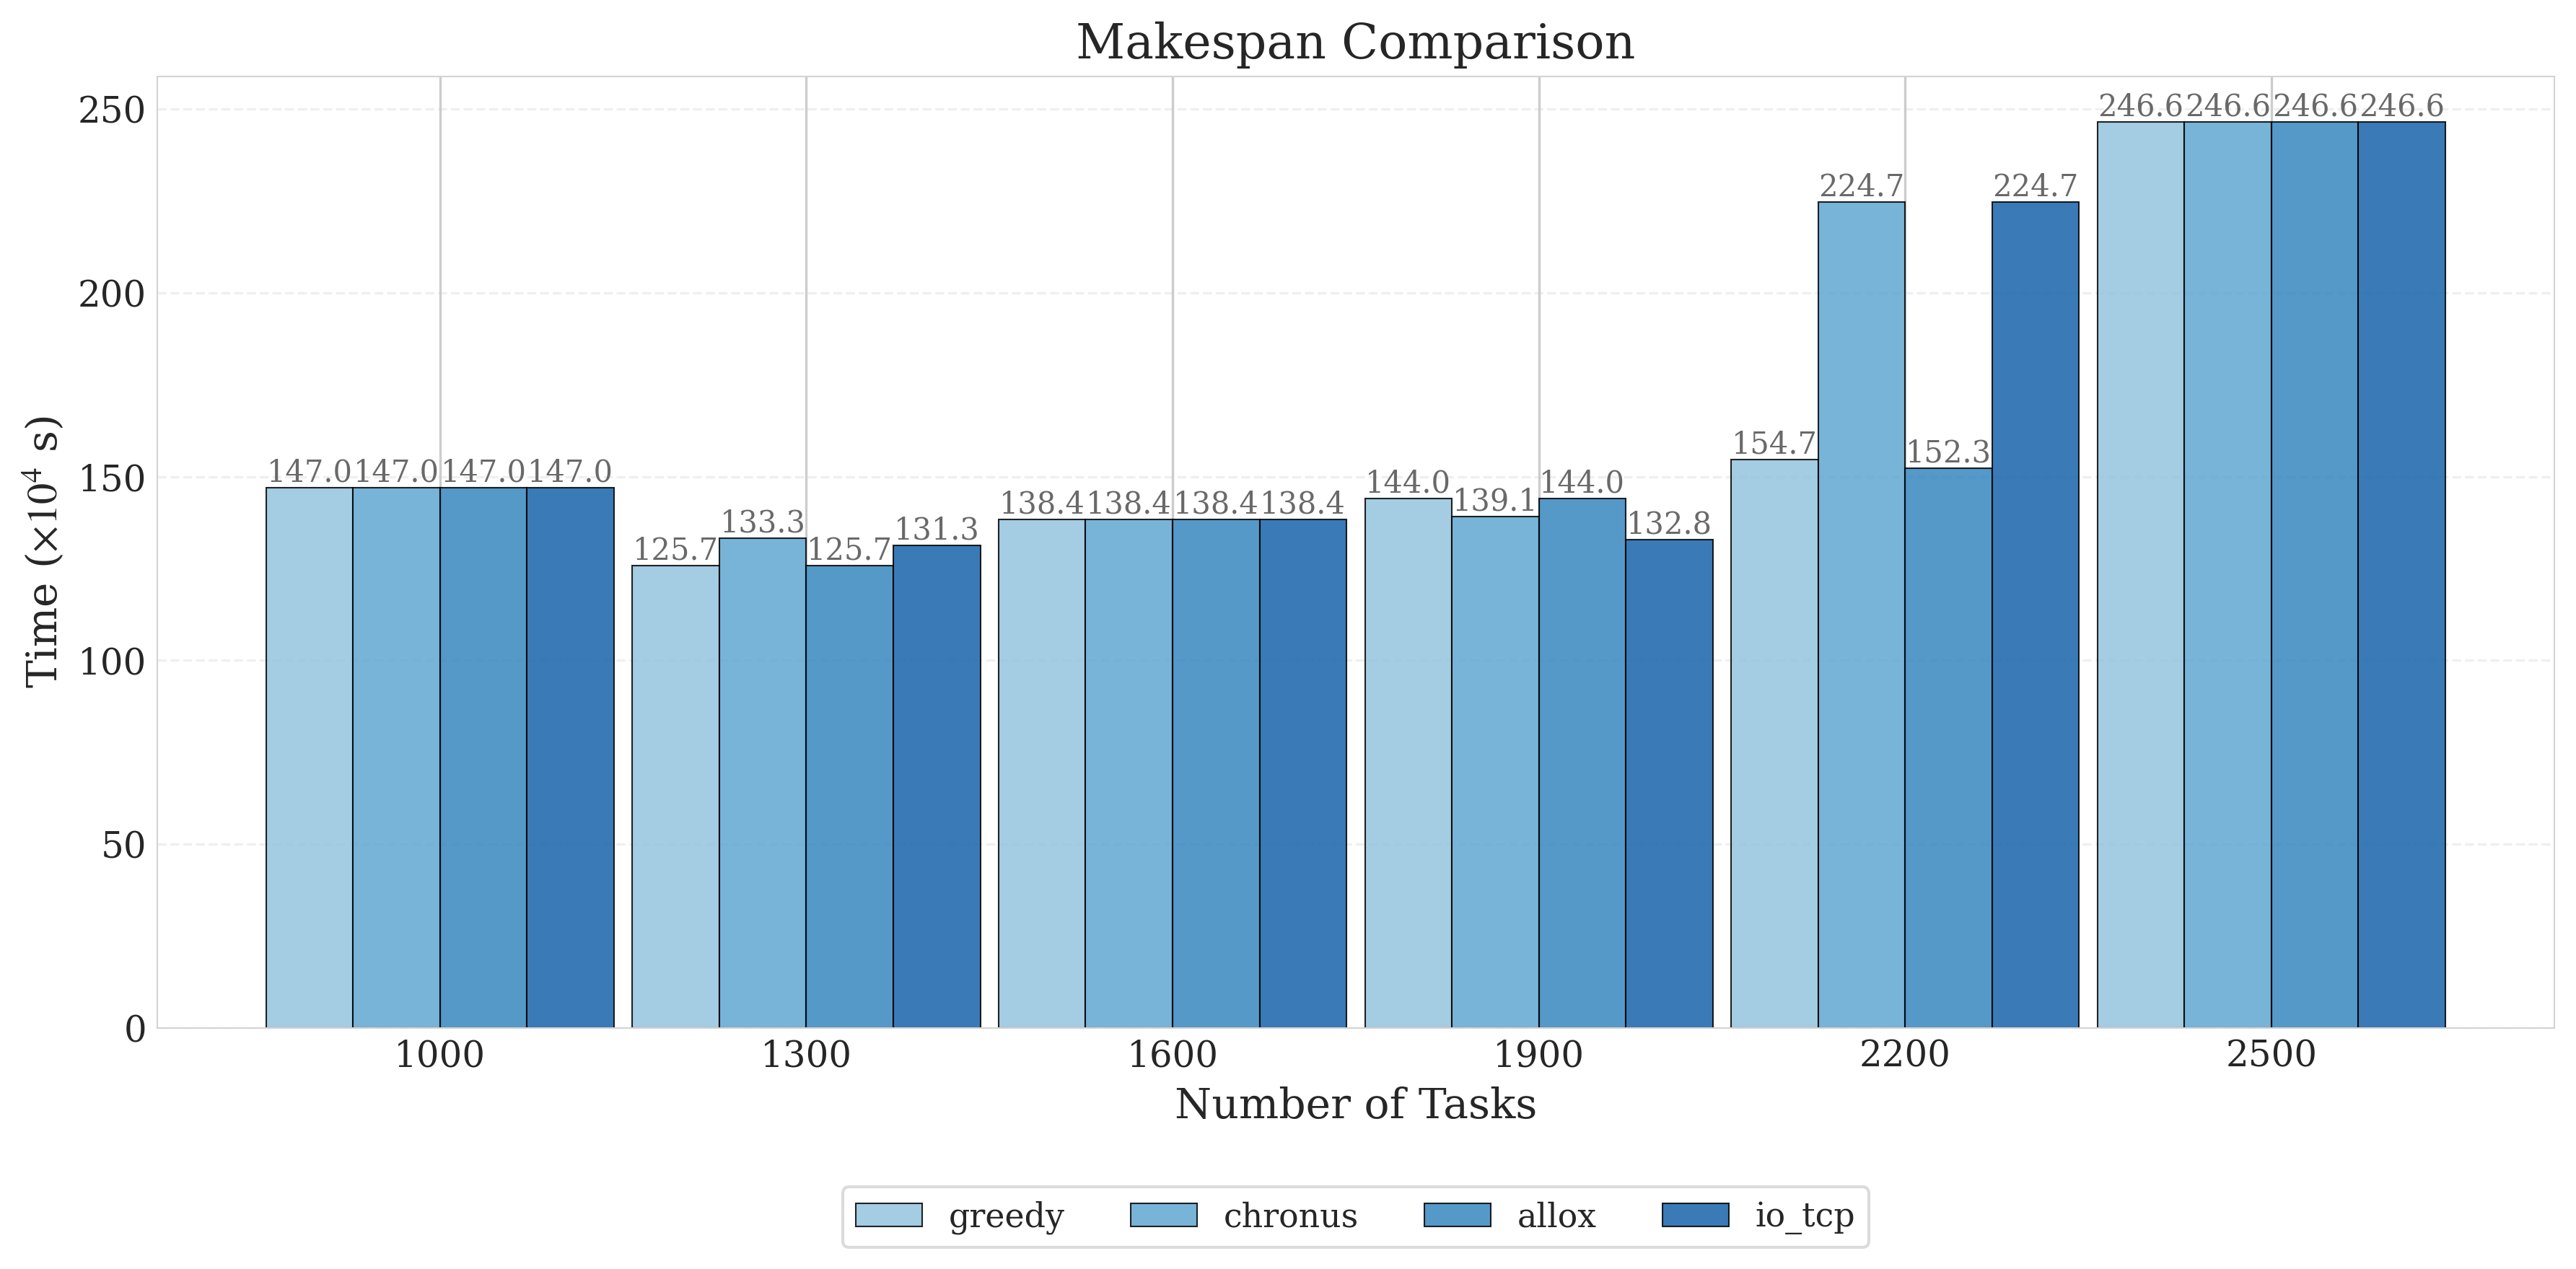

In [2]:
def plot_metrics_comparison(results_dict):
    """绘制不同任务数量下各调度器的性能比较柱状图"""
    import matplotlib.pyplot as plt
    import numpy as np

    # 设置绘图样式
    plt.style.use("seaborn-v0_8-whitegrid")
    plt.rcParams.update(
        {
            "font.family": "serif",
            "font.serif": ["Times New Roman", "DejaVu Serif", "Palatino", "serif"],
            "mathtext.fontset": "stix",
            "axes.labelsize": 14,  # 从11增加到14
            "axes.titlesize": 16,  # 从12增加到16
            "xtick.labelsize": 12,  # 从10增加到12
            "ytick.labelsize": 12,  # 从10增加到12
            "legend.fontsize": 11,  # 从9增加到11
        }
    )

    # 获取调度器列表和任务数量列表
    schedulers = list(results_dict[list(results_dict.keys())[0]].keys())
    jobs_counts = sorted(list(results_dict.keys()))  # 确保任务数量有序

    # 使用不同的颜色方案
    colors = plt.cm.Blues(np.linspace(0.4, 0.8, len(schedulers)))

    # 设置柱状图的宽度
    width = 0.95 / len(schedulers)  # 根据调度器数量自动调整宽度

    # 指标列表
    metrics = [("avg_queue_time", "Queue Delay"), ("avg_running_time", "JCT"), ("total_runtime", "Makespan")]

    # 为每个指标创建单独的图
    for metric_attr, metric_name in metrics:
        plt.figure(figsize=(12, 6), dpi=300)
        ax = plt.gca()

        # 为每个调度器绘制柱状图
        for scheduler_idx, scheduler in enumerate(schedulers):
            x_positions = np.arange(len(jobs_counts))
            values = [results_dict[jobs_count][scheduler].__getattribute__(metric_attr) for jobs_count in jobs_counts]

            # 计算柱子的位置
            x = x_positions + scheduler_idx * width - (len(schedulers) - 1) * width / 2

            # 绘制柱状图
            bars = ax.bar(
                x,
                [v / 1e4 for v in values],
                width,
                label=scheduler,
                color=colors[scheduler_idx],
                edgecolor="black",
                linewidth=0.5,
                alpha=0.85,
            )

            # 添加数据标签
            for i, v in enumerate(values):
                ax.text(x[i], v / 1e4, f"{v/1e4:.1f}", ha="center", va="bottom", fontsize=10, color="dimgray")

        # 设置图表样式
        ax.set_title(f"{metric_name} Comparison")
        ax.set_xlabel("Number of Tasks")
        ax.set_ylabel("Time ($\\times 10^4$ s)")

        # 设置x轴刻度
        ax.set_xticks(x_positions)
        ax.set_xticklabels(jobs_counts)

        # 设置网格线
        ax.grid(True, axis="y", linestyle="--", alpha=0.3)

        # 美化边框
        for spine in ax.spines.values():
            spine.set_visible(True)
            spine.set_linewidth(0.5)
            spine.set_color("lightgray")

        # 添加图例
        plt.legend(
            bbox_to_anchor=(0.5, -0.15), loc="upper center", ncol=len(schedulers), frameon=True, edgecolor="lightgray"
        )

        # 调整布局
        plt.tight_layout()
        plt.subplots_adjust(bottom=0.2)

        plt.show()
        plt.close()


# 使用示例
plot_metrics_comparison(results_dict)

In [3]:
def calculate_metrics_reduction(results_dict, compare_scheduler):
    """计算CED策略相对于其他调度器的各项指标降低百分比

    Args:
        results_dict: 包含不同任务数量下各调度器结果的字典

    Returns:
        dict: 每个任务数量下各指标的降低百分比
    """
    metrics_reduction = {}

    # 遍历每个任务数量
    for job_count in results_dict.keys():
        metrics_reduction[job_count] = {"queue_delay": {}, "jct": {}, "makespan": {}}

        results = results_dict[job_count]

        # 获取CED的基准值
        ced_queue_delay = results[compare_scheduler].avg_queue_time
        ced_jct = results[compare_scheduler].avg_running_time
        ced_makespan = results[compare_scheduler].total_runtime

        # 计算相对于其他调度器的降低百分比
        for scheduler in results.keys():
            if scheduler == compare_scheduler:
                continue

            # 计算队列等待时间降低百分比
            queue_delay = results[scheduler].avg_queue_time
            queue_reduction = ((queue_delay - ced_queue_delay) / queue_delay) * 100
            metrics_reduction[job_count]["queue_delay"][scheduler] = queue_reduction

            # 计算JCT降低百分比
            jct = results[scheduler].avg_running_time
            jct_reduction = ((jct - ced_jct) / jct) * 100
            metrics_reduction[job_count]["jct"][scheduler] = jct_reduction

            # 计算Makespan降低百分比
            makespan = results[scheduler].total_runtime
            makespan_reduction = ((makespan - ced_makespan) / makespan) * 100
            metrics_reduction[job_count]["makespan"][scheduler] = makespan_reduction

    return metrics_reduction


def print_metrics_reduction(metrics_reduction):
    """打印各项指标的降低百分比"""
    metrics_names = {"queue_delay": "Queue Delay", "jct": "JCT", "makespan": "Makespan"}

    for job_count in metrics_reduction.keys():
        print(f"\n任务数量: {job_count}")
        for metric_key, metric_name in metrics_names.items():
            print(f"\nCED的{metric_name}降低百分比相对于其他调度器:")
            for scheduler, reduction in metrics_reduction[job_count][metric_key].items():
                print(f"{scheduler}: 降低了 {reduction:.2f}%")


# 使用示例
metrics_reduction = calculate_metrics_reduction(results_dict, base_scheduler)
print_metrics_reduction(metrics_reduction)


任务数量: 1000

CED的Queue Delay降低百分比相对于其他调度器:
greedy: 降低了 17.42%
chronus: 降低了 15.68%
allox: 降低了 18.92%

CED的JCT降低百分比相对于其他调度器:
greedy: 降低了 15.03%
chronus: 降低了 13.72%
allox: 降低了 16.48%

CED的Makespan降低百分比相对于其他调度器:
greedy: 降低了 0.00%
chronus: 降低了 0.00%
allox: 降低了 0.00%

任务数量: 1300

CED的Queue Delay降低百分比相对于其他调度器:
greedy: 降低了 33.19%
chronus: 降低了 7.47%
allox: 降低了 43.11%

CED的JCT降低百分比相对于其他调度器:
greedy: 降低了 31.46%
chronus: 降低了 6.81%
allox: 降低了 41.18%

CED的Makespan降低百分比相对于其他调度器:
greedy: 降低了 -4.42%
chronus: 降低了 1.49%
allox: 降低了 -4.42%

任务数量: 1600

CED的Queue Delay降低百分比相对于其他调度器:
greedy: 降低了 15.21%
chronus: 降低了 1.72%
allox: 降低了 31.65%

CED的JCT降低百分比相对于其他调度器:
greedy: 降低了 14.29%
chronus: 降低了 1.35%
allox: 降低了 30.20%

CED的Makespan降低百分比相对于其他调度器:
greedy: 降低了 -0.00%
chronus: 降低了 0.00%
allox: 降低了 -0.00%

任务数量: 1900

CED的Queue Delay降低百分比相对于其他调度器:
greedy: 降低了 40.75%
chronus: 降低了 19.69%
allox: 降低了 40.90%

CED的JCT降低百分比相对于其他调度器:
greedy: 降低了 39.75%
chronus: 降低了 18.98%
allox: 降低了 39.90%

CED的Makespan降低百分比相对于其他调度器:
greedy